# RESTify Controled Experiment Data Analysis

This Jupyter Notebook illustrates the design and results obtained throughout the McGill RESTify Controled Experiment.
 * For more information on the experiment, visit the [RESTify Experiment Recruitment Page](https://www.cs.mcgill.ca/~mschie3/recruitment/).
 * For a PDF version of our findings, visit [LINK TBA WHEN WE HAVE PUBLISHED](...).
 * To follow up our methodology and reproduce all our results and analysis **on your machine**, continue reading...

## Step 1 - Representative population and fair group partition

Our first challenge was the creation of representative control groups. The experiment layout required us to form four groups of equal size, with a comparable skill set. We [implemented a heuristic algorithm](https://github.com/m5c/RecruitmentFormInterpreter) that analyzed participant profiles to form comparable control groups. This step was notably challenging because of the combinatoric overhead of possible combinations and participants reactively retracting from the study, which required several rounds of recruitment. Yet we were able to form adequate control groups. The details of this first step and statistics to indicate their comparability are described in the following.

### Test population

We recruited 28 software engineers from various backgrounds. By consequence the individual skill profiles were highly diverse, a factor that we consider desirable for the relevance of the experiment. The skill vectors were extractede from a preliminary recruitment procedure, where participants were [asked to provide a self evaluation of their skills](https://www.cs.mcgill.ca/~mschie3/recruitment/self-assessment.txt), where 1 signifies no and 5 signifies expert knowledge. We acknowledge that self-assessments are subjective and hard to verify. Yet the questions were phrased in a manner that forwarded objective results.

#### Diversity

The next cell computes and displays the overall skill distribution of our final test population. The individual gaussian curves represent the seven skills requested in the test assessment form:
 * Proficiency in JAVA (Light Grey)
 * Proficiency with the Spring Framework (Mint)
 * Proficiency with the Build-System Maven (Light Blue)
 * Knowledge about the Modeling Tool TouchCORE (Deep Purple)
 * Proficiency with the UNIX/OS command line (Pink)
 * Knowledge about the REST networking paradigm (Red)
 * Knowledge about the Singleton pattern (Orange)
 * Knowledge about Reflection in programming languages (Dark Grey)
 We acknowledge that we obtain a considerable deviation for all the above skills:


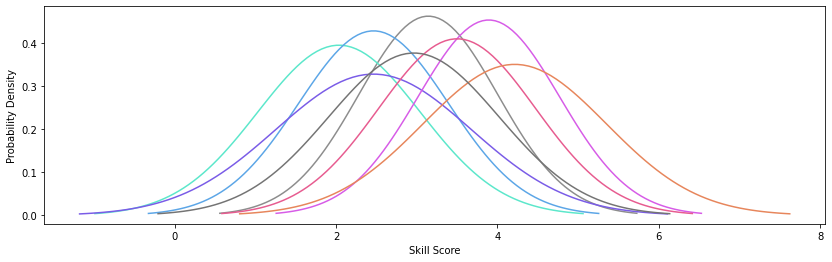

In [7]:
# display_population_gaussian.py
"""
This module reads participant skills from the participantskills.csv file, computes the gaussian
distributions per skill and creates a plot. The output file is stored in:
"generated-plots/gaussian.png"
Author: Maximilian Schiedermeier
"""

from restify_mining.data_objects import participant_stat_tools
from restify_mining.markers import skills_markers
from restify_mining.data_objects.participant import Participant
from restify_mining.plotters.skill_plotter import plot_gaussian
from csv_tools import file_load_utils

# Load all participant objects (specifies skills, codename, control-group) from csv file
population: list[Participant] = file_load_utils.load_all_participants()

# Compute a gaussian distribution (defined by mean and standard dev) for every skill and produce
# plot
mean_scores = participant_stat_tools.build_mean_skills(population)
stddev_scores = participant_stat_tools.build_standard_deviation_skills(population)

# Plot gaussian curves for all participant skills
for index in range(len(skills_markers.skill_tags)):
    plot_gaussian(mean_scores[index], stddev_scores[index], skills_markers.palette[index])



TODO: also print grid values. Reuse table from recruitment.md here.
---
The above densities can be considered sufficiently diverse for the purpose of our study. Although the population showcases varying average skill scores, the population likewise showcases a substantial score diversity for every skill observed. Yet we are acknowledge that the above data stems from subjective self-evaluations and is not necessarily a ground truth indicator for the population's actual skill diversity.

### Control groups

Goal of the experiment is the comparison of refactoring methodologies. To eliminate learning effects we asked participants to apply the two methodologies on different applications. Eliminating potential bias by task and application order resulted in a participant repartition into four control groups.

#### Heuristic Search for MiniMax
We ran a heuristic balancing algorithm to obtain control groups with high comparability in regards to their average score per skill. The algorithm searched for the participant distribution with lowest difference in skill differences per pair of team. Specifically, on every iteration we used the highest score difference on the same skill for any pair of control groups as quality metric. The original partitions were highly comparable: For every tested partition, we computed the highest difference for skill scores between any pair of teams. Goal was to minimize the value as far as possible, resulting in control groups that are highly comparable in any skill. We called this goal the search for the *MiniMax*. The value obtained through our heuristic for the originally recruited population was as low as ```0.6```, that means no matter what skill and pair of groups compared, the average difference in skill was guaranteed to be equal or lower to ```0.6```.

#### Droppers
Unfortunately participants dropped out, even after having committed to a task. At this point we were able to hire replacements, however it was impossible to re-generate a fully optimized new control group repartition. At this point we had already received the first test results and since due to learning effects the study can not be run twice by the same participant, we had to reduce optimizations to a brute force testing of all permutations of dropped out participants and potential replacements. This adjustment had to be repeated three times, since participants kept dropping out, even after deadline extensions and reassured intent of participation.  
Yet finally we were able to conclude the study with a population of 28 participants. Although comparability is not as optimal as in the original distribution, we were lucky enough to have ended up with somewhat comparable control groups.

The full boxplot of skill distributions per control group and resulting MiniMax (grid, printed in bold) is generated below:

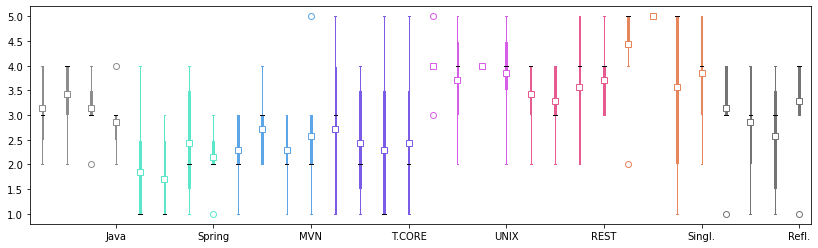

In [2]:
# display_control_group_skill_boxplot.py
"""
This module reads participant skills from the participantskills.csv file, computes then a boxplot
distribution representation per skill and group and fuses all resulting representation into a png
file. The output file is stored in:
"generated-plots/boxplot.png"
Author: Maximilian Schiedermeier
"""

from restify_mining.data_objects import participant_filter_tools
from restify_mining.data_objects.participant import Participant
from restify_mining.markers.skills_markers import skill_tags, palette
from restify_mining.plotters.skill_plotter import plot_box
from csv_tools import file_load_utils

# Load all participant objects (specifies skills, codename, control-group) from csv file
population: list[Participant] = file_load_utils.load_all_participants()

# Creating the boxplot comes down to ordering all raw skill values of all participants into the
# order required by the plotter. The statistical markers are then extracted automatically.
# Namely, the required order is: all values for skill 1 of participants of group 1, all values
# for skill 1 of participants of group 2, ... all values for skill 2 of participants of group 1,
# and so on...
plotter_skill_values = []
control_groups: list[str] = participant_filter_tools.extract_group_names(population)

# To fill the plotter_skill_value list, first iterate over all skills in outer loop
for skill_index in range(len(skill_tags)):

    # Next: per skill iterate over all participants ordered by control group in inner loop
    for control_group in control_groups:
        control_group_population = participant_filter_tools.filter_population_by_group(population, control_group)

        # Append the value every participant of the current control group has for the current skill
        plotter_skill_values.append(
            participant_filter_tools.get_skill_values_by_index(control_group_population,
                                                               skill_index))

# Finally feed the long list of all skill values in the order, required by the box plotter
plot_box(plotter_skill_values, palette, len(control_groups), "generated-plots/fused-stats.png")

In [3]:
# compute_group_skill_diffs

"""
This module computes and prints the maximum skill difference between any pair of control groups,
for all skill. Highlights the greatest (worst competence comparability) of these values as metric
for the given control group distribution. A preliminary goal in search for a meaningful partition
was the minimization of this value (Search for MiniMax). The current value is worse is not the best
possible solution, since the population evolved over time (enrolled participants dropping out and
being replaced).
Author: Maximilian Schiedermeier
"""

from restify_mining.data_objects.participant import Participant
from restify_mining.data_objects import participant_filter_tools as pft
from restify_mining.markers.skills_markers import full_skill_tags, skill_tags, get_formated_skill_tag
from csv_tools import file_load_utils

# Print disclaimer
print(
    "Control group comparability analysis. Listing of greatest differences (average skill values) "
    "between any pairs of control groups:")

# Load all participant objects (specifies skills, codename, control group) from csv file
population: list[Participant] = file_load_utils.load_all_participants()

# Prepare variables to remember worst average difference and corresponding index
worst_min_max_diff: float = 0.0
worst_min_max_diff_index: int = 0

# Iterate over skills and for each compute the average score difference for any pair of control
# groups. Print the highest (worst) value found.
control_groups: list[str] = pft.extract_group_names(population)
for skill_index, skill in enumerate(skill_tags):

    # Compute average skill value for each control group
    average_skill_values = []
    for control_group in control_groups:
        control_group_population = pft.filter_population_by_group(population, control_group)
        average_skill_values.append(
            pft.get_average_skill_value_by_index(control_group_population, skill_index))

    # Print line with lowers, highest and max diff values for given skill:
    avg_min: float = min(average_skill_values)
    avg_max: float = max(average_skill_values)
    avg_min_max_diff = avg_max - avg_min

    # Update high-score if the results for this skill are worse than anything encountered so far
    if avg_min_max_diff > worst_min_max_diff:
        worst_min_max_diff = avg_min_max_diff
        worst_min_max_diff_index = skill_index

    # Print the stats for the current skill
    print(get_formated_skill_tag(skill_index) + ": \tAVG_MIN=" + str(round(avg_min, 1))
          + ",\tAVG_MAX=, " + str(round(avg_max, 1)) +
          ",\tMAX_AVG_DIFF=" + str(round(avg_max - avg_min, 1)))

# Print the name of the skill that serves as metric for this partition.
print("--------------")
print(
    "The worst difference in average skill values between two control groups in the given "
    "partition appears for:")
print("\t\"" + full_skill_tags[worst_min_max_diff_index] + "\", with a difference of " + str(
    round(worst_min_max_diff, 1)))


Control group comparability analysis. Listing of greatest differences (average skill values) between any pairs of control groups:
Java	: 	AVG_MIN=2.9,	AVG_MAX=, 3.4,	MAX_AVG_DIFF=0.6
Spring	: 	AVG_MIN=1.7,	AVG_MAX=, 2.4,	MAX_AVG_DIFF=0.7
MVN	: 	AVG_MIN=2.3,	AVG_MAX=, 2.7,	MAX_AVG_DIFF=0.4
T.CORE	: 	AVG_MIN=2.3,	AVG_MAX=, 2.7,	MAX_AVG_DIFF=0.4
UNIX	: 	AVG_MIN=3.7,	AVG_MAX=, 4.0,	MAX_AVG_DIFF=0.3
REST	: 	AVG_MIN=3.3,	AVG_MAX=, 3.7,	MAX_AVG_DIFF=0.4
Singl.	: 	AVG_MIN=3.6,	AVG_MAX=, 5.0,	MAX_AVG_DIFF=1.4
Refl.	: 	AVG_MIN=2.6,	AVG_MAX=, 3.3,	MAX_AVG_DIFF=0.7
--------------
The worst difference in average skill values between two control groups in the given partition appears for:
	"Singleton", with a difference of 1.4


## Step 2 - Fusing the data

Throughout the experiment we measured different metrics per participant. Those are stored in separate CSV files. Some of them were auto-generated by additional scripts, some were created by hand.  
In a first step we are going to fuse all individual CSV files, using the *participant codename* as key. The codename consists of a colour and an animal.

 > We used a total of 4 control groups, *Red*, *Green*, *Blue*, *Yellow*, each starring 7 participants. This setup was chosen to reduce learning effects.
 
 The outcome of below cell is a new file: ```restify.csv```.  
 This file lists all data we ever process in the following, indexed by *participant codename*.

In [4]:
"""
This module updates the fused csv based on the current partial csv files found in
"source-csv-files", persists the outcome to disk and displays the content.
"""
from csv_tools import csv_merger

# Call the CSV merger, fuses all individual files based on participant group/codename as key.
csv_merger.build_merged_csv()

# Print the result
restify_csv = open("generated-csv-files/restify.csv", "r").read()
print(restify_csv)


codename,controlgroup,animal,javaskill,springskill,mavenskill,touchcoreskill,unixskill,restskill,singletonskill,reflectionskill,groupindex,firstapp,secondapp,firstmethodology,secondmethodology,tcinstructions,ideinstructions,xoxtime,bookstoretime,xoxverified,bsverified,tccomments,idecomments,assistedstatus,assistedsuccessrate,manualstatus,manualsuccessrate,GET/xox,POST/xox,GET/xox/id,DEL/xox/id,GET/xox/id/board,GET/xox/id/players,GET/xox/id/players/id/actions,POST/xox/id/players/id/actions/actionid,GET/bookstore/isbns,GET/bookstore/isbns/isbn,PUT/bookstore/isbns/isbn,GET/bookstore/stocklocations,GET/bookstore/stocklocations/stocklocation,GET/bookstore/stocklocations/stocklocation/isbns,POST/bookstore/stocklocations/stocklocation/isbns,GET/bookstore/isbns/isbn/comments,POST/bookstore/isbns/isbn/comments,DEL/bookstore/isbns/isbn/comments,POST/bookstore/isbns/isbn/comments/comment,DEL/bookstore/isbns/isbn/comments/comment
Red-Squid,red,squid,3,1,2,1,4,2,5,1,0,bookstore,xox,touchcore,manual

# Step 3 - Data Analysis

 * Overall population performance, all methodologies, all applications
    * Overall population performance, manual tasks (percentage)
    * Overall population performance, assisted tasks (percentage)

Here comes a great and intuitive to read text that explains how the unit-test plot is produced and how to read the results.

Key points:

  * Black horizontal bars: all tests failed because the submission did not compile or was not executable.
  * Black vertical bars: A test that failed for many participants.

    TODO: plot needs more labels.

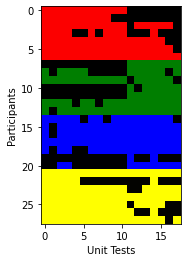

In [5]:
from csv_tools import file_load_utils
from restify_mining.data_objects.assessed_participant import AssessedParticipant
from restify_mining.unit_test_miners.all_participants_all_tests_miner import AllParticipantsAllTestsMiner
from restify_mining.plotters.unit_test_plotter import mine_and_plot

# Load all participant objects (specifies skills, codename, control-group) from csv file
assessed_population: list[
    AssessedParticipant] = file_load_utils.load_all_assessed_participants()

# Create a 2D plot of all individual participant test results. On Y axis (vertical) all
# participants, on X axis (horizontal) all unit tests. Created image shows a black square for
# failed tests, coloured square (matching control group colour) for passed tests.
with_colours: bool = True
mine_and_plot(AllParticipantsAllTestsMiner(), with_colours, assessed_population)

## Similar, a heatmap with the average test results per control group (TODO, split into applications)

Here comes a great and intuitive to read text that explains how the heatmap plot is produced and how to read the results.


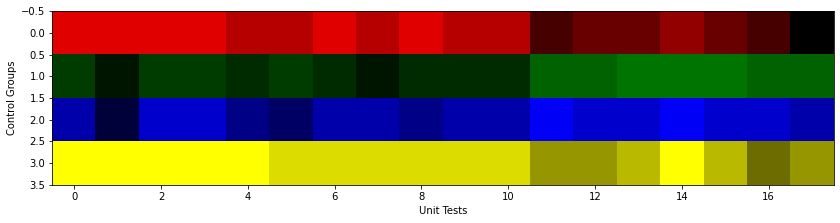

In [6]:
from csv_tools import file_load_utils
from restify_mining.data_objects.assessed_participant import AssessedParticipant
from restify_mining.plotters import unit_test_plotter

# Load all participant objects (specifies skills, codename, control-group) from csv file
assessed_population: list[
    AssessedParticipant] = file_load_utils.load_all_assessed_participants()

# Visualize test results in 2D plot and safe to disk
unit_test_plotter.plot_all_average_group_results(assessed_population)